In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import trimesh
import torch
import numpy as np
import random
import imageio
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import h5py
from tqdm import trange

In [4]:
import Render_opencv as Render
# Render.extIOR, Render.intIOR = 1.0, 1.15
Render.extIOR, Render.intIOR = 1.0, 1.5
resy=960
resx=1280
Float = torch.float64
# Float = torch.float32
device='cuda'
Render.resy = resy
Render.resx = resx
Render.device = device
Render.Float = Float

In [12]:
import h5py
from PIL import Image
resy=960
resx=1280
def cal_valid_mask(src):
    # src = cv2.GaussianBlur(src, (3, 3), 0)
    lap = cv2.Laplacian(src, cv2.CV_64F,ksize=1,)
    lap = np.linalg.norm(lap,axis=2)
    mask = (lap>1e-3)*(lap<20)
    # mask = (lap>1e-3)
    # kernel = np.ones((5,5),np.uint8) 
    # mask = cv2.morphologyEx(mask.astype(np.uint8),cv2.MORPH_CLOSE, kernel)
    # mask = cv2.erode(mask.astype(np.uint8), kernel)
    # mask = (mask>0)
    return mask

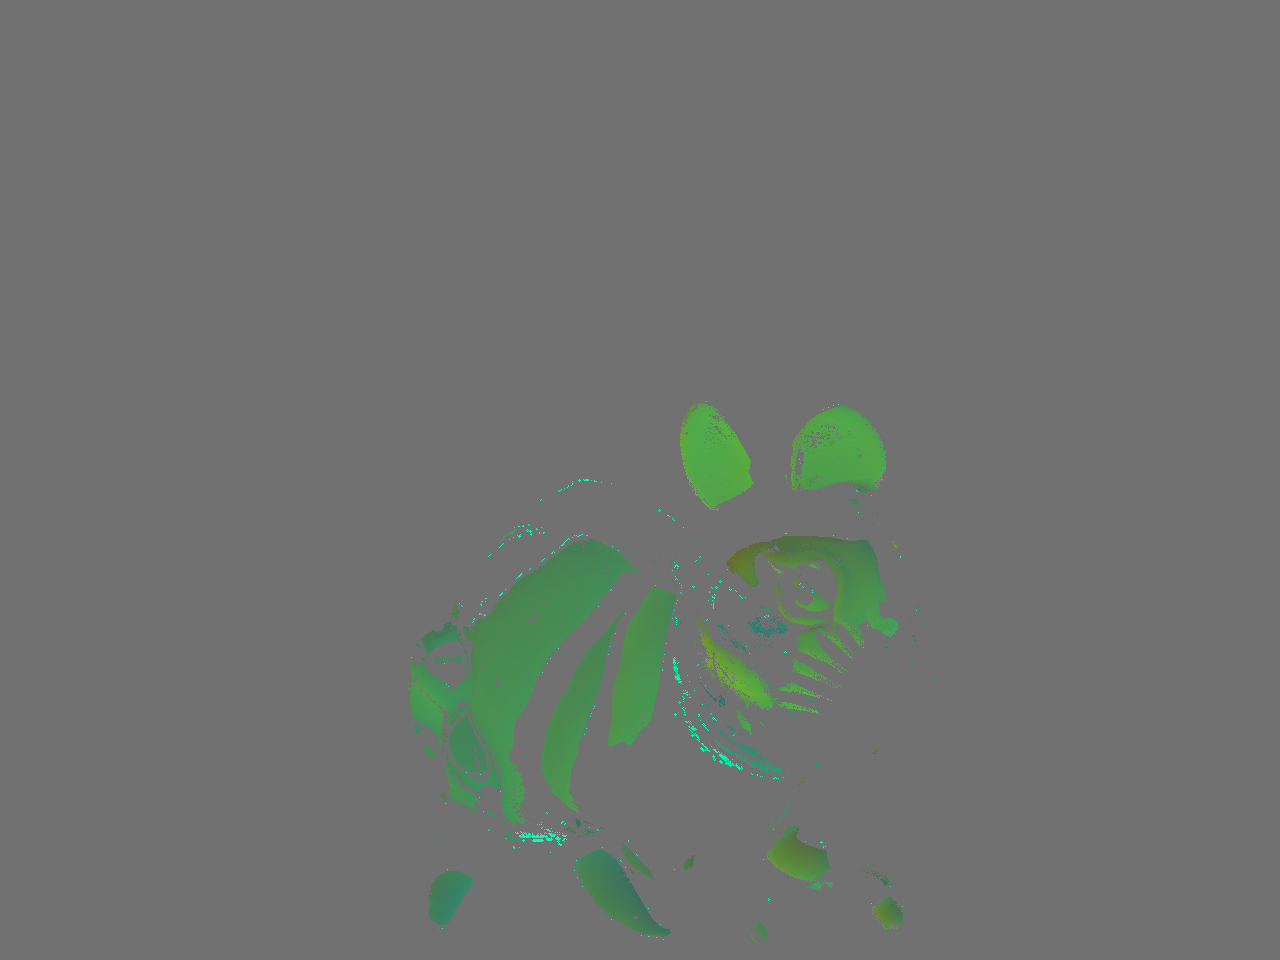

In [19]:
i = 10
name = 'mouse'
h5data = h5py.File(f'/root/workspace/data/{name}.h5','r')
out_dir = h5data['ray'][i,:,-3:]
out_ori = h5data['ray'][i,:,-6:-3]
mask = h5data['mask'][i][:,:,0]/255

# kernel = np.ones((3,3),np.uint8) 
# mask = cv2.erode(mask, kernel)

img = out_ori
# img = cv2.GaussianBlur(img.reshape((resy,resx,-1)), (3, 3),0).reshape((-1,3))
# img = out_ori * mask.reshape((-1,1))

# valid = (cal_valid_mask(out_dir) * mask).reshape(-1)
valid = cal_valid_mask(img.reshape((resy,resx,3))).reshape((-1,1))
img = img * valid * mask.reshape((-1,1))
img = img.reshape((resy,resx,-1))
# anchor = img[500,600]
# anchor_mask = np.linalg.norm(img - anchor, axis=2)>10
# kernel = np.ones((3,3),np.uint8) 
# anchor_mask = cv2.morphologyEx(anchor_mask.astype(np.uint8),cv2.MORPH_CLOSE, kernel)
# anchor_mask = cv2.erode(anchor_mask.astype(np.uint8), kernel)
# anchor_mask = (anchor_mask>0)
# img = anchor_mask[:,:,np.newaxis] * img

image = (255 * (img-img.min()) / (img.max()-img.min())).astype(np.uint8)
Image.fromarray(image)

In [ ]:
img.max()

In [ ]:
from skimage.restoration import denoise_nl_means
img = out_ori  * valid.reshape((-1,1)) * mask.reshape((-1,1))
img = denoise_nl_means(img.reshape((resy,resx,3)), multichannel=True,h=0.2)
image = (255 * (img-img.min()) / (img.max()-img.min())).astype(np.uint8)
Image.fromarray(image.reshape((resy,resx,-1)))

In [ ]:
camera_proj = np.genfromtxt('/root/workspace/data/TransRecon_RealCapturedDate/real/mouse/1/proj.csv', delimiter=',')
row4=np.array([0,0,0,1.]).reshape(1,-1)
camera_proj = np.concatenate((camera_proj,row4),axis=0)
R = np.linalg.inv(camera_proj)

In [70]:
camera_proj @ np.array([0,0,0,1]).T

array([ -1.12864, -35.5121 , 666.905  ,   1.     ])

In [68]:
print(np.linalg.inv(h5data['cam_proj'][0]) @ camera_proj @ np.array([1,1,0,1]).T)

[   1.10868827  144.72306478 -105.71451491    1.        ]


In [59]:
out_ori[0]

array([-335.51,  464.07, -839.96])

In [ ]:
def valid_mask(out_ray):
    src = out_ray.reshape((resy,resx,3))
    # src = cv2.GaussianBlur(src, (3, 3), 0)
    lap = cv2.Laplacian(src, cv2.CV_64F)
    lap = np.linalg.norm(lap,axis=2)
    mask = (lap>1e-2)*(lap<0.5)
    kernel = np.ones((5,5),np.uint8) 
    mask = cv2.morphologyEx(mask.astype(np.uint8),cv2.MORPH_CLOSE, kernel)
    return (mask>0)

In [ ]:
# h5data = h5py.File('/root/workspace/data/monkey_ray.h5','r')
h5data = h5py.File('/root/workspace/data/mouse.h5','r')
Views = []
for i in trange(72):
# for i in [0,36]:
    out_ray = h5data['ray'][i,:,-3:]
    mask = h5data['mask'][i][:,:,0]
    origin = h5data['ray'][i,:,:3]
    ray_dir = h5data['ray'][i,:,3:6]
    R_inverse = h5data['cam_proj'][i]
    K = h5data['cam_k'][:]
    R = np.linalg.inv(R_inverse)
    K_inverse = np.linalg.inv(K)
    valid = (valid_mask(out_ray) * mask).reshape(-1)
    M = mask
    bound = 2
    dist= (cv2.distanceTransform(M, cv2.DIST_L2, 0)-1).clip(0,bound)\
     - (cv2.distanceTransform(255-M, cv2.DIST_L2, 0)-1).clip(0,bound)
    mask = (dist + bound) / (2*bound)

    camera_M = (R, K, R_inverse, K_inverse)
    Views.append((out_ray, valid, mask, origin, ray_dir, camera_M))

In [ ]:

out_ray, valid, mask, origin, ray_dir, camera_M = Views[0]
R, K, R_inverse, K_inverse = camera_M
out_ray = torch.tensor(out_ray, dtype=Float, device=device)
valid = torch.tensor(valid, dtype=bool, device=device)
mask = torch.tensor(mask, dtype=Float, device=device)
origin = torch.tensor(origin, dtype=Float, device=device)
ray_dir = torch.tensor(ray_dir, dtype=Float, device=device)
R_inverse = torch.tensor(R_inverse, dtype=Float, device=device)
K_inverse = torch.tensor(K_inverse, dtype=Float, device=device)
R = torch.tensor(R, dtype=Float, device=device)
K = torch.tensor(K, dtype=Float, device=device)
camera_M = (R, K, R_inverse, K_inverse)
target = out_ray
render_mask = scene.render_mask(origin, ray_dir)
render_img, render_twice_mask = scene.render_transparent(origin, ray_dir)
silhouette_edge = scene.silhouette_edge(origin[0])
index, output = scene.primary_visibility(silhouette_edge, camera_M, origin[0], detach_depth=True)
# Render.torch2pil(render_mask-mask.view(-1))

In [ ]:
img = out_ray.clone()
img[torch.logical_not(valid)]=0
Render.torch2pil(img)

In [ ]:
src = h5data['ray'][3,:,-3:].reshape((resy,resx,3))
# src = cv2.GaussianBlur(src, (3, 3), 0)
lap = cv2.Laplacian(src, cv2.CV_64F)
lap = np.linalg.norm(lap,axis=2)
mask = (lap<1e-4)+(lap>5)

kernel = np.ones((5,5),np.uint8) 
mask = cv2.morphologyEx(mask.astype(np.uint8),cv2.MORPH_CLOSE, kernel)
src[mask>0]=0
img = src
image = (255 * (img-img.min()) / (img.max()-img.min())).astype(np.uint8)
Image.fromarray(image)

In [ ]:
(mask>0).shape

In [ ]:

refr = out_ray
Render.torch2pil(refr)

In [ ]:
mask.view((resy,resx))[index[:,1],index[:,0]] = 2
Render.torch2pil(mask)
# mask.max()

In [ ]:
pix_i = scene.project_vert(camera_M, vh_vertices)
render_mask.view((resy,resx))[pix_i[:,1],pix_i[:,0]] = 2
Render.torch2pil(render_mask)

In [ ]:
# scene = Render.Scene("/root/workspace/data/TransRecon_RealCapturedDate/real-mini/monkey/monkey_carved_fixed.ply")
# scene = Render.Scene("/root/workspace/data/monkey_vh.ply")
scene = Render.Scene("/root/workspace/data/mouse_vh.ply")
vh_vertices = scene.vertices
vh_normals = torch.tensor(scene.mesh.vertex_normals, dtype=Render.Float, device=device)
vh_faces = torch.tensor(scene.mesh.faces, device=device)
parameter = torch.zeros(vh_vertices.shape, dtype=Float, requires_grad=True, device=device)
def limit_hook(grad):
    grad[grad>1]=1
    grad[grad<-1]=-1
    return grad
parameter.register_hook(limit_hook)

# opt = torch.optim.SGD([parameter], lr=.001, momentum = 0.9, nesterov =True)
# opt = torch.optim.SGD([parameter], lr=0.1, momentum = 0.9, nesterov =True)
opt = torch.optim.Adam([parameter], lr=0.05)

e1 = scene.mesh.vertices[scene.mesh.edges[:,0]]
e2 = scene.mesh.vertices[scene.mesh.edges[:,1]]
mean_len = np.linalg.norm(e1-e2, axis=1).mean()


In [ ]:
Render.extIOR, Render.intIOR = 1.0, 1.4723
def area_var(vertices):
    v0=vertices[vh_faces[:,0]]
    v1=vertices[vh_faces[:,1]]
    v2=vertices[vh_faces[:,2]]
    edge1 = v1-v0
    edge2 = v2-v0
    area =torch.cross(edge1,edge2).norm(dim=1)
    area_ave = area.mean().detach()
    area_var = ((area-area_ave)/area_ave).pow(2).mean()
    return area_var

for it in range(1999):
    V_index = random.randint(0, len(Views)-1)
    out_ray, valid, mask, origin, ray_dir, camera_M = Views[V_index]
    R, K, R_inverse, K_inverse = camera_M
    out_ray = torch.tensor(out_ray, dtype=Float, device=device)
    valid = torch.tensor(valid, dtype=bool, device=device)
    mask = torch.tensor(mask, dtype=Float, device=device)
    origin = torch.tensor(origin, dtype=Float, device=device)
    ray_dir = torch.tensor(ray_dir, dtype=Float, device=device)
    R_inverse = torch.tensor(R_inverse, dtype=Float, device=device)
    K_inverse = torch.tensor(K_inverse, dtype=Float, device=device)
    R = torch.tensor(R, dtype=Float, device=device)
    K = torch.tensor(K, dtype=Float, device=device)
    camera_M = (R, K, R_inverse, K_inverse)
    target = out_ray

    # Zero out gradients before each iteration
    opt.zero_grad()
    vertices = vh_vertices + parameter
    scene.update_verticex(vertices)

    render_img, render_twice_mask = scene.render_transparent(origin, ray_dir)
    diff = (render_img - target)
    valid_mask = (diff.norm(dim=1)<0.5) * valid * render_twice_mask[:,0]
    # loss = 1e3*(render_img[twice_mask]-target[twice_mask]).pow(2).mean()
    # loss = 1e2*(render_img[twice_mask]-target[twice_mask]).pow(2).mean()
    # loss = 1e2*(render_img[twice_mask]-target[twice_mask]).abs().mean()
    loss = 1e2*(diff[valid_mask]).pow(2).mean()

    silhouette_edge = scene.silhouette_edge(origin[0])
    index, output = scene.primary_visibility(silhouette_edge, camera_M, origin[0], detach_depth=True)
    vh_loss = 1e2 * (mask.view((resy,resx))[index[:,1],index[:,0]] - output).abs().mean()
  
    # sm_loss = 1e2*torch.norm(laplac/mean_len, dim=1).pow(2).mean()     
    area_loss = 2*area_var(vertices)
    ((loss+vh_loss+area_loss)).backward()

    # (sm_loss+vh_loss).backward()
    if it%100==0:
        print('Iteration %03i:  error=%g vh=%g grad=%g' % (it, loss, vh_loss, parameter.grad.abs().max()))
        # print('Iteration %03i: sm=%g vh=%g  area=%g grad=%g  ' % (it, sm_loss, vh_loss, area_loss, parameter.grad.abs().max()))
    opt.step()

    vertices = vh_vertices + parameter
    laplac = vertices.detach() - scene.weightM.mm(vertices.detach()) 
    vh_vertices -= 0.3 * laplac
    vertices = vh_vertices + parameter
    laplac = vertices.detach() - scene.weightM.mm(vertices.detach()) 
    vh_vertices += 0.3 * laplac
    # sm_loss = 1e2*torch.norm(laplac/mean_len, dim=1).pow(2).mean()  

In [ ]:
_=scene.mesh.export("result/mouse.ply")

In [ ]:
img = out_ray.clone()
img[torch.logical_not(valid_mask)]=0
Render.torch2pil(img)

In [ ]:
img = render_img.clone()
img[torch.logical_not(valid_mask)]=0
Render.torch2pil(img)

In [ ]:
render_img[twice_mask]

In [ ]:

V = vh_vertices
W = torch.ones([V.shape[0],1], dtype=Float, device=device)
hemo_v = torch.cat([V, W], dim=1) #[Nx4]
v_camera = R_inverse @ hemo_v.T #[3xN]
v_camera = K @ v_camera[:3]
pixel_index = v_camera[:2] / v_camera[2]

W = torch.ones([1, pixel_index.shape[1]], dtype=Float, device=device)
camera_p = K_inverse @ torch.cat([pixel_index, W], dim=0) # pixel at z=1
camera_p = torch.cat([camera_p, W], dim=0)
world_p = R @ camera_p #[4x2n]
world_p = world_p[:3].T #[2nx3]

In [ ]:
(world_p - origin[0])  / (world_p - origin[0]).norm(dim=1,keepdim=True)

In [ ]:
(V - origin[0]) / (V - origin[0]).norm(dim=1,keepdim=True)

In [ ]:
img = imageio.imread('/root/workspace/data/TransRecon_RealCapturedDate/real/mouse/1/obj_gray/obj_gray_01/col_gray_02.png')

In [ ]:
blur = cv2.GaussianBlur(img,(5,5),0)
th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,511,9)
Image.fromarray(th)

In [ ]:
blur = cv2.GaussianBlur(img,(5,5),0)
ret,thOTSU = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
Image.fromarray(thOTSU)

In [ ]:
cv2.Laplacian?